In [56]:
import torch
from torch import nn
from d2l import torch as d2l

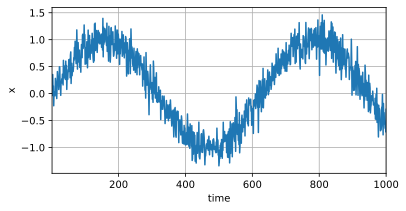

In [57]:
T = 1000                                                            # 生成1000个时间步
time = torch.arange(1, T + 1, dtype=torch.float32)                  # 生成时间序列
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))             # 生成序列数据
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))    # 绘制序列数据

In [58]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

# 代码原理
- 在时间序列预测中，通常使用过去的几个时间点的数据来预测下一个时间点的值。这里的关键设计有：
    1. 滑动窗口：tau = 4 表示使用连续的4个时间步作为特征
    2. 样本数量：T - tau（996个样本）是因为：
        - 第一个样本：使用时间步 [0,1,2,3] 预测时间步 4
        - 第二个样本：使用时间步 [1,2,3,4] 预测时间步 5
- 特征维度：每个样本包含 tau (4) 个时间步的数据作为特征
    - features[:, 0]设置为x[0:996]，即[x0, x1, ..., x995]
    - features[:, 1]设置为x[1:997]，即[x1, x2, ..., x996]
    - features[:, 2]设置为x[2:998]，即[x2, x3, ..., x997]
    - features[:, 3]设置为x[3:999]，即[x3, x4, ..., x998]
    - labels设置为x[4:]，即[x4, x5, ..., x999]
    这样每个特征向量都对应一个预测标签，实现了滑动窗口的特征构建。

In [59]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [60]:
# 训练模型
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.060066
epoch 2, loss: 0.049508
epoch 3, loss: 0.047146
epoch 4, loss: 0.045563
epoch 5, loss: 0.046257


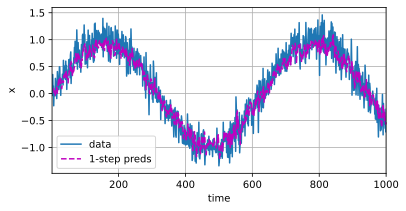

In [61]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

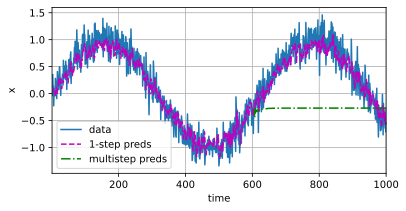

In [62]:
# 采用序列模型的输出作为输入，进行多步预测 
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau: i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

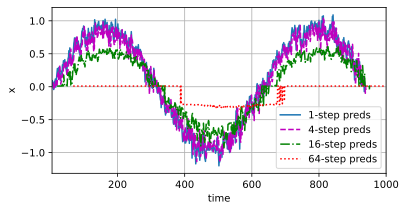

In [63]:
# 计算多步预测的误差
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

# 总结
内插法（在现有观测值之间进行估计）和外推法（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。

序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。

对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。

对于直到时间步
的观测序列，其在时间步
的预测输出是“
步预测”。随着我们对预测时间
值的增加，会造成误差的快速累积和预测质量的极速下降。

